In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

dimensions = train_set[0][0].shape
img_size = torch.prod(torch.tensor(dimensions))

Files already downloaded and verified
Files already downloaded and verified


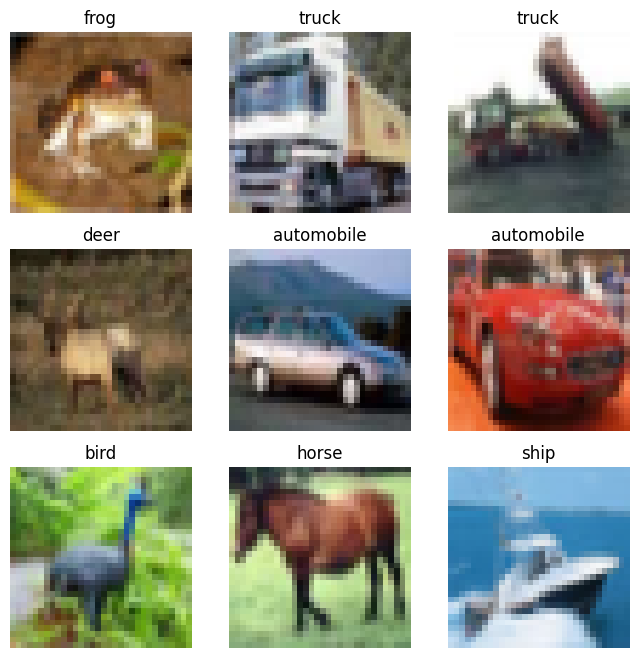

In [2]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set.data[i]
    axs[i//3, i%3].imshow(img, cmap='gray')
    axs[i//3, i%3].set_title(train_set.classes[train_set.targets[i]])
    axs[i//3, i%3].axis('off')


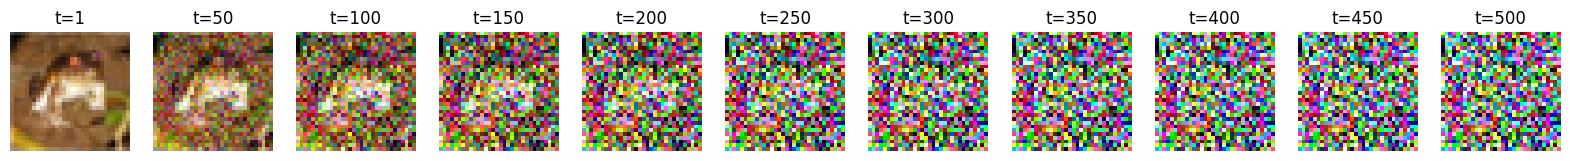

In [3]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 500
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0][0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(3, 32, 32).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.show()


A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel.
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. 
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

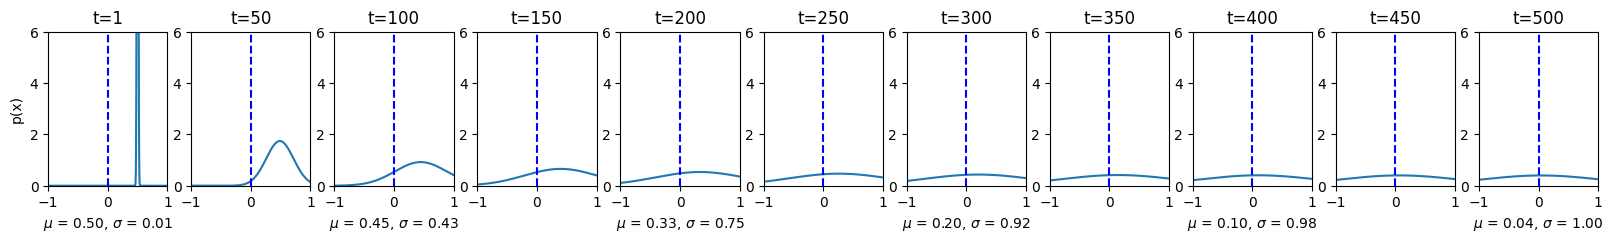

In [4]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('p(x)')

To show that the distribution of the final layer actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 514.64it/s]


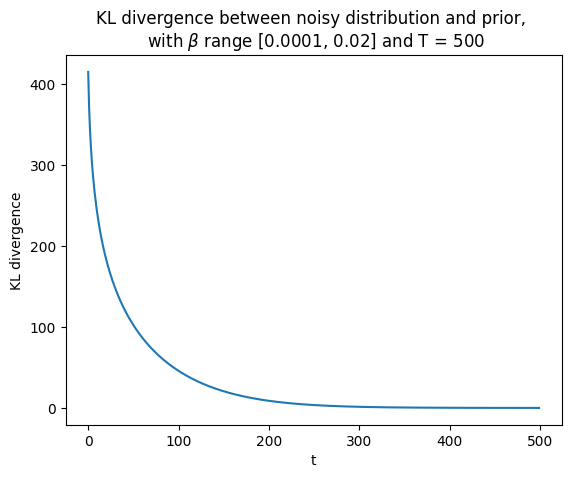

In [5]:
from tqdm import tqdm

x0_small = train_set[0][0].flatten()[:100] ## make a small image to speed up computation
## this small image is just a 10x10 patch of the original image
N = len(x0_small)

p_T = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(N), torch.eye(N))
def make_noisy_distribution(t):
    q_mu = noise_schedule.sqrt_alpha_hat[t] * x0_small.flatten()
    q_std = noise_schedule.sqrt_one_minus_alpha_hat[t]
    q_xT_given_q_x0 = torch.distributions.multivariate_normal.MultivariateNormal(q_mu, torch.eye(N)*q_std**2)
    return q_xT_given_q_x0
KL_list = np.zeros(T)
for i in tqdm(range(T)):
    q_xT_given_q_x0 = make_noisy_distribution(i)
    KL_list[i] = torch.distributions.kl_divergence(q_xT_given_q_x0, p_T).detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("KL divergence")
plt.show()


We somehow have to encode the different timesteps. Here, we'll use sinusoidal encoding. 


Text(0.5, 0, 'd')

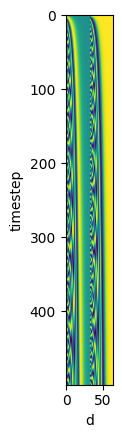

In [6]:
time_dimension = 64

def SinusoidalEmbeddings(ts):
    half_dim =  time_dimension // 2
    embeddings = torch.log(torch.tensor(10000)) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim).float() * -embeddings)
    embeddings = ts.view(-1, 1).float() * embeddings.view(1, -1)
    embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=1)

    return embeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings)
plt.ylabel("timestep")
plt.xlabel("d")


We use a UNet model to predict the noise in the images.

In [7]:
from utils import ResNET

model = ResNET()
dummy_input = torch.randn(4, 3, 32, 32)
dummy_time = noise_schedule.sample_time_steps(4)
dummy_embeddings = SinusoidalEmbeddings(dummy_time)
dummy_output = model(dummy_input, dummy_embeddings)

print("input shape: ", dummy_input.shape)
print("time shape: ", dummy_time.shape)
print("embeddings shape: ", dummy_embeddings.shape)
print("output shape: ", dummy_output.shape)


input shape:  torch.Size([4, 3, 32, 32])
time shape:  torch.Size([4, 1])
embeddings shape:  torch.Size([4, 64])
output shape:  torch.Size([4, 3, 32, 32])


Sampling image..
Done sampling image


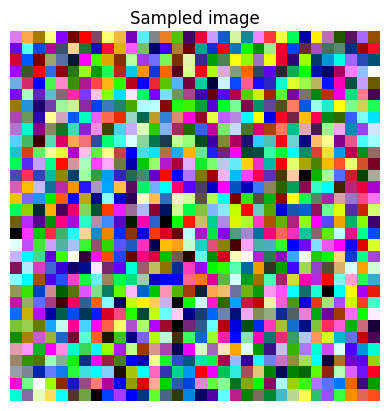

In [15]:
import torch.nn as nn

optimizer = torch.optim.Adam(model.parameters())
mse = nn.MSELoss()
batch_size = train_loader.batch_size
epochs = 50

def sample_image():
    with torch.no_grad():
        xt = torch.randn((1, img_size))
        print("Sampling image..")
        for t in reversed(range(1, 2)):
            embedding = SinusoidalEmbeddings(torch.tensor(t).view(1,1))
            
            eps = model(xt.view(1, *dimensions), embedding).flatten()

            k1 = 1 / noise_schedule.sqrt_alpha[t]
            k2 = (1 - noise_schedule.alpha[t]) / noise_schedule.sqrt_one_minus_alpha_hat[t]

            xt = k1 * (xt - k2 * eps)
            if t > 1:
                xt += noise_schedule.sigma[t] * torch.randn((1, img_size))

        print("Done sampling image")

        return xt

def sample_and_show_image(title="Sampled image"):
    xt = sample_image()
    img = xt.view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def simple_loss(x0):
    ts = noise_schedule.sample_time_steps(batch_size)
    embeddings = SinusoidalEmbeddings(ts)
    xt, eps, _ = noise_schedule.make_noisy_images(x0.flatten(1), ts)
    xt = xt.view(batch_size, *dimensions)
    pred = model(xt, embeddings)
    loss = mse(pred.flatten(1), eps)
    return loss

for epoch in range(epochs):
    losses = torch.zeros(batch_size)

    for i, (x0, _) in enumerate(tqdm(train_loader)):
        loss = simple_loss(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses[i] = loss.item()

    print(f"Epoch: {epoch}")
    print(losses.mean().item())